In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (
    DiagramBuilder,
    DirectCollocation,
    PiecewisePolynomial,
    MeshcatVisualizer,
    StartMeshcat,
    Solve,
)
from helper import (
    CartMultiPendulumSystem,
    CartMultiPendulumEquilibriumState,
    CartMultiPendulumStabilizingController
)

In [3]:
meshcat = StartMeshcat()
meshcat.Set2dRenderMode(xmin=-6.6, xmax=6.6, ymin=-3.1, ymax=3.1)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [112]:
cart_multi_pendulum = CartMultiPendulumSystem(m1=1,l1=1, m2=1,l2=1, m3=1,l3=1)

builder = DiagramBuilder()
builder.AddNamedSystem("CartMultiPendulum", cart_multi_pendulum)

visualizer = MeshcatVisualizer.AddToBuilder(builder, cart_multi_pendulum.get_output_port(1), meshcat)

diagram = builder.Build()

In [153]:
dircol = DirectCollocation(
    cart_multi_pendulum,
    cart_multi_pendulum.CreateDefaultContext(),
    num_time_samples=50,
    minimum_time_step=0.01,
    maximum_time_step=0.1
)
prog = dircol.prog()

x_start = CartMultiPendulumEquilibriumState(['down', 'up', 'down'])
prog.AddBoundingBoxConstraint(x_start, x_start, dircol.initial_state())

x_target = CartMultiPendulumEquilibriumState(['up', 'up', 'up'])
prog.AddBoundingBoxConstraint(x_target, x_target, dircol.final_state())

u_trj_init = PiecewisePolynomial()
x_trj_init = PiecewisePolynomial.FirstOrderHold([0.0, 4.0], np.vstack([x_start, x_target]).T)
dircol.SetInitialTrajectory(u_trj_init, x_trj_init)

result = Solve(prog, prog.initial_guess())
print("Found trajectory? ", result.is_success())

Found trajectory?  True


In [155]:
root_context = diagram.CreateDefaultContext()
visualizer_context = visualizer.GetMyContextFromRoot(root_context)

visualizer.StartRecording()

x_trj = dircol.ReconstructStateTrajectory(result)

for t in np.linspace(x_trj.start_time(), x_trj.end_time(), 1000):
    root_context.SetTimeAndContinuousState(t, x_trj.value(t))
    visualizer.ForcedPublish(visualizer_context)

visualizer.StopRecording()
visualizer.PublishRecording()

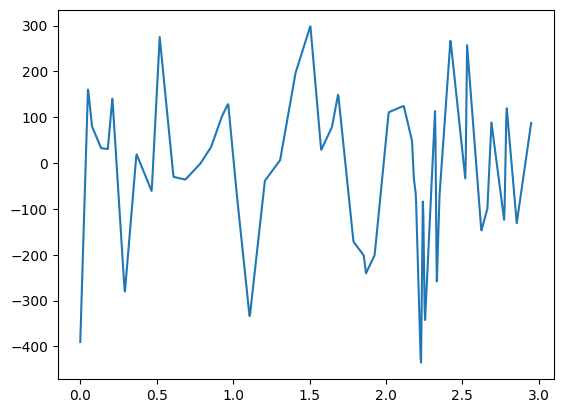

In [150]:
u_trj = dircol.ReconstructInputTrajectory(result)
t = np.linspace(u_trj.start_time(), u_trj.end_time(), 1000)
u = u_trj.vector_values(t)
plt.plot(t, u[0,:])